## Cohort Analysis and Customer Segmentation

Cohort analysis is a subset of behavioural analytics that takes the data from a given data set (e.g. an EMRS, an e-commerce platform, web application, or online game) and rather than looking at all users as one unit, it breaks them into related groups for analysis (Wikipedia). There are 3 main types of cohorts: Time cohorts, behaviour cohorts and size cohorts.
Analysing cohorts is the door opens to customer segmentations, which allows businesses to tailor appropriate actions to each of the customer groups. 

In this analysis, I will focus on:
- Time cohorts - CohortMonth
- Calculating the retention rate 
- Calculating the average number of items each month
- Customer segmentation bases on Recency, Frequency and Monetary values with KMeans

### About the dataset 
The dataset was donated by an online retail business in the UK in the period of 13 months from Dec 2010 to Dec 2011. It's downloaded from https://archive.ics.uci.edu/ml/datasets/online+retail, for more details about the overal online analysis of this business, please refer to my previous work at: https://github.com/huesk8er/Applied-Marketing/blob/main/CLTVandSalesPrediction.ipynb

In [1]:
#Loading libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt

In [2]:
#Loading the dataset
online = pd.read_csv('/Users/huedinh/Desktop/Data projects/Onlineretail/OnlineRetail.csv', engine='python')
online.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


### Cohort Month

In [3]:
#Creating 2 columns InvoiceMonth and CohortMonth by substracting year, month from InvoiceDate
online['InvoiceDate'] = pd.to_datetime(online['InvoiceDate'])

#Assign aquisition month cohort

def get_month(x): return dt.datetime(x.year, x.month,1)

online['InvoiceMonth'] = online['InvoiceDate'].apply(get_month)
grouping = online.groupby('CustomerID')['InvoiceMonth']
online['CohortMonth'] = grouping.transform('min')
online.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,InvoiceMonth,CohortMonth
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,2010-12-01,2010-12-01
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,2010-12-01,2010-12-01
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,2010-12-01,2010-12-01
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,2010-12-01,2010-12-01
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,2010-12-01,2010-12-01


In [4]:
#Extract Interger values from data
#Define function to extract year, month and day interger values

def get_date_int(df, column):
    year = df[column].dt.year
    month = df[column].dt.month
    day = df[column].dt.day
    return year, month, day


In [5]:
# Creating CohortIndex column by assigning time offset values 

invoice_year, invoice_month, _ = get_date_int(online, 'InvoiceMonth')
cohort_year, cohort_month, _ = get_date_int(online, 'CohortMonth')
year_diff = invoice_year - cohort_year
month_diff = invoice_month - cohort_month
online['CohortIndex'] = year_diff*12 + month_diff + 1
online.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,InvoiceMonth,CohortMonth,CohortIndex
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,2010-12-01,2010-12-01,1.0
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,2010-12-01,2010-12-01,1.0
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,2010-12-01,2010-12-01,1.0
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,2010-12-01,2010-12-01,1.0
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,2010-12-01,2010-12-01,1.0


### Retention rate
Customer retention is the metric to understand how many of all the customers are still active. It is Percentage of active customers out of total customers This is the key metric to identify the performance of customer service and marketing activity. Maintain a high retention rate is crutial for the sucessful of the business, as it's much more expensive to enquire a new customer than keeping the existing one happy to keep using your products/services. 


In [7]:
#Count monthly active customers from each cohort
grouping = online.groupby(['CohortMonth', 'CohortIndex'])
cohort_data = grouping['CustomerID'].apply(pd.Series.nunique)
cohort_data = cohort_data.reset_index()
cohort_data['CohortMonth'] = cohort_data['CohortMonth'].dt.date
cohort_counts = cohort_data.pivot(index = 'CohortMonth',
                                 columns = 'CohortIndex',
                                 values = 'CustomerID')
cohort_counts

CohortIndex,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,11.0,12.0,13.0
CohortMonth,,,,,,,,,,,,,
2010-12-01,948.0,362.0,317.0,367.0,341.0,376.0,360.0,336.0,336.0,374.0,354.0,474.0,260.0
2011-01-01,421.0,101.0,119.0,102.0,138.0,126.0,110.0,108.0,131.0,146.0,155.0,63.0,NaN
2011-02-01,380.0,94.0,73.0,106.0,102.0,94.0,97.0,107.0,98.0,119.0,35.0,NaN,NaN
2011-03-01,440.0,84.0,112.0,96.0,102.0,78.0,116.0,105.0,127.0,39.0,NaN,NaN,NaN
2011-04-01,299.0,68.0,66.0,63.0,62.0,71.0,69.0,78.0,25.0,NaN,NaN,NaN,NaN
2011-05-01,279.0,66.0,48.0,48.0,60.0,68.0,74.0,29.0,NaN,NaN,NaN,NaN,NaN
2011-06-01,235.0,49.0,44.0,64.0,58.0,79.0,24.0,NaN,NaN,NaN,NaN,NaN,NaN
2011-07-01,191.0,40.0,39.0,44.0,52.0,22.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-08-01,167.0,42.0,42.0,42.0,23.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:

#Calculate retention rate
#Store the first column as the cohort-size
cohort_sizes = cohort_counts.iloc[:,0]

#Divide all values of cohort_counts by cohort_sizes
retention = cohort_counts.divide(cohort_sizes, axis = 0)

#Review the retention table:
retention.round(3)*100


CohortIndex,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,11.0,12.0,13.0
CohortMonth,,,,,,,,,,,,,
2010-12-01,100.0,38.2,33.4,38.7,36.0,39.7,38.0,35.4,35.4,39.5,37.3,50.0,27.4
2011-01-01,100.0,24.0,28.3,24.2,32.8,29.9,26.1,25.7,31.1,34.7,36.8,15.0,NaN
2011-02-01,100.0,24.7,19.2,27.9,26.8,24.7,25.5,28.2,25.8,31.3,9.2,NaN,NaN
2011-03-01,100.0,19.1,25.5,21.8,23.2,17.7,26.4,23.9,28.9,8.9,NaN,NaN,NaN
2011-04-01,100.0,22.7,22.1,21.1,20.7,23.7,23.1,26.1,8.4,NaN,NaN,NaN,NaN
2011-05-01,100.0,23.7,17.2,17.2,21.5,24.4,26.5,10.4,NaN,NaN,NaN,NaN,NaN
2011-06-01,100.0,20.9,18.7,27.2,24.7,33.6,10.2,NaN,NaN,NaN,NaN,NaN,NaN
2011-07-01,100.0,20.9,20.4,23.0,27.2,11.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-08-01,100.0,25.1,25.1,25.1,13.8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<AxesSubplot:xlabel='CohortIndex', ylabel='CohortMonth'>

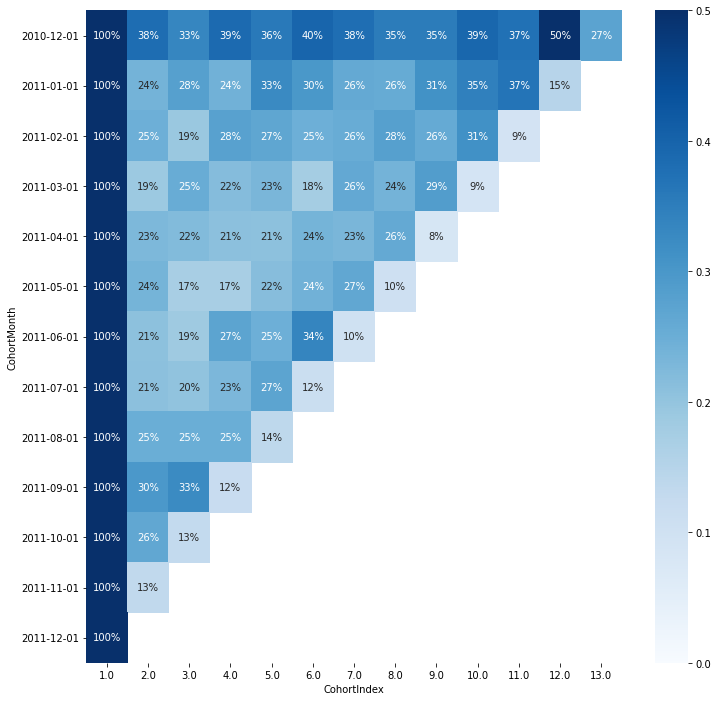

In [8]:
#Plotting retention rate with the heatmap
plt.figure(figsize=(12, 12))
sns.heatmap(data = retention,
           annot = True,
           fmt = '.0%',
           vmin = 0,
           vmax = 0.5,
           cmap = 'Blues')

Customers who started their mebership from Dec, 2010 has highest intention rate compares to all other months. 
And they returning customers are much higher by the end of the year. 

### Average quantity per purchase


In [10]:
grouping = online.groupby(['CohortMonth', 'CohortIndex'])
cohort_data = grouping['Quantity'].mean()
cohort_data = cohort_data.reset_index()
cohort_data['CohortMonth'] = cohort_data['CohortMonth'].dt.date
average_quantity = cohort_data.pivot(index = 'CohortMonth',
                                 columns = 'CohortIndex',
                                     values = 'Quantity')

average_quantity.round(1)

CohortIndex,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,11.0,12.0,13.0
CohortMonth,,,,,,,,,,,,,
2010-12-01,11.0,14.6,15.0,14.8,12.9,14.3,15.2,14.8,16.7,16.7,17.3,12.8,14.8
2011-01-01,10.0,12.6,12.3,10.9,12.2,14.9,14.2,14.4,11.4,9.9,9.1,9.5,NaN
2011-02-01,10.8,12.1,18.6,12.0,11.1,11.4,13.3,12.4,10.3,11.9,12.6,NaN,NaN
2011-03-01,9.8,9.9,12.2,9.5,13.6,12.3,13.2,12.2,10.5,8.9,NaN,NaN,NaN
2011-04-01,9.8,10.1,9.4,11.6,11.5,8.2,9.7,9.3,7.3,NaN,NaN,NaN,NaN
2011-05-01,10.9,9.0,13.9,11.8,10.9,8.7,10.1,7.4,NaN,NaN,NaN,NaN,NaN
2011-06-01,10.3,13.7,10.5,13.3,10.2,9.8,9.3,NaN,NaN,NaN,NaN,NaN,NaN
2011-07-01,9.7,12.7,7.1,7.8,6.0,7.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-08-01,9.9,6.0,5.3,6.0,7.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<AxesSubplot:xlabel='CohortIndex', ylabel='CohortMonth'>

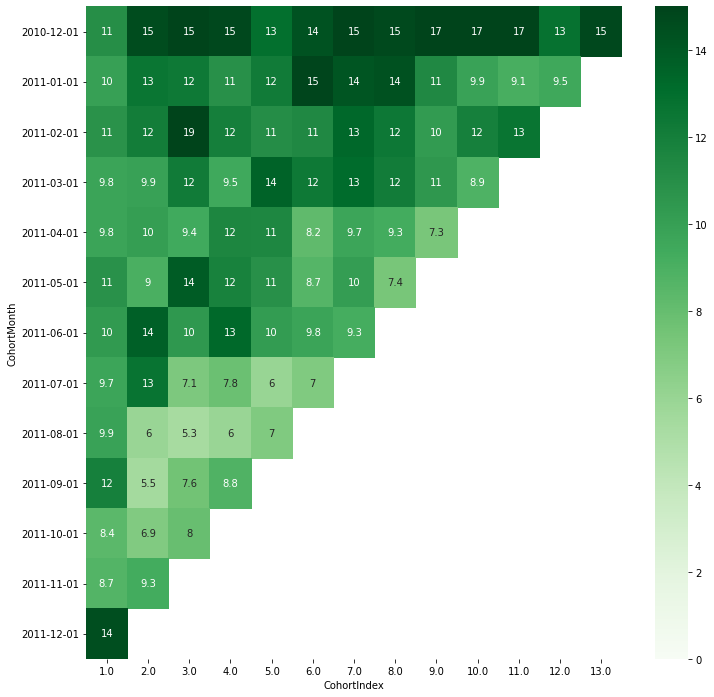

In [13]:
plt.figure(figsize=(12, 12))
sns.heatmap(data = average_quantity,
           annot = True,
           vmin = 0,
           vmax = 15,
           cmap = 'Greens')

Not only the higher retention rate, the customers who purchased their first bills on Dec 2010 to March 2011 has a significant higher average quantity of items. 

### Recency, Frequency and Monetary Values (RFM)

They are 3 main matrics to classify customers:
Recency (How recently did the customer make a purchase?)
Frequency (How often do they purchase)
Monetary Value (How much do they spend?)

An RFM analysis evaluates which customers are of highest and lowest value to an organization based on purchase recency, frequency, and monetary value, in order to reasonably predict which customers are more likely to make purchases again in the future.

In [9]:
#RFM metrics calculations
#Recency: Days since the customer made the transaction
#Frequency: Number of transactions in the last 12 months 
#Monetary values: Total spend in the last 12 months 

#Data preparation steps
print('Min:{}, Max:{}'.format(min(online.InvoiceDate),
                             max(online.InvoiceDate)))

#Create a hypothetical snapshot day
snapshot_date = max(online.InvoiceDate) + dt.timedelta(days = 1)

Min:2010-12-01 08:26:00, Max:2011-12-09 12:50:00


In [10]:
online['Totalsum'] = online['Quantity']*online['UnitPrice']
#Calculating the RFM metrics
datamart = online.groupby(['CustomerID']).agg({
    'InvoiceDate' : lambda x: (snapshot_date - x.max()).days,
    'InvoiceNo': 'count',
    'Totalsum':'sum'})
#Rename columns for easier interpertation 
datamart.rename(columns = {'InvoiceDate':'Recency',
                          'InvoiceNo':'Frequency',
                          'Totalsum':'MonetaryValue'}, inplace = True)

In [11]:
#Buliding RFM segments
r_labels = range(4, 0, -1)
r_quartiles = pd.qcut(datamart['Recency'], q = 4, labels = r_labels)
datamart = datamart.assign(R =r_quartiles.values)
f_labels = range(1,5)
m_labels = range(1,5)
f_quartiles = pd.qcut(datamart['Frequency'], q = 4, labels = f_labels)
m_quartiles = pd.qcut(datamart['MonetaryValue'], q = 4, labels = m_labels)
datamart = datamart.assign(F =f_quartiles.values)
datamart = datamart.assign(M =m_quartiles.values)

In [12]:
#Build RMF segment and RMF score
def join_rfm(x): return str(x['R']) + str(x['F']) + str(x['M'])
datamart['RFM_Segment'] = datamart.apply(join_rfm, axis = 1)
datamart['RFM_Score'] = datamart[['R','F','M']].sum(axis = 1)

In [13]:
#Analysing RMF table
datamart.groupby('RFM_Segment').size().sort_values(ascending = False)[:10]

RFM_Segment
4.04.04.0    471
1.01.01.0    392
1.02.02.0    209
3.04.04.0    206
2.01.01.0    181
3.03.03.0    176
2.02.02.0    173
2.03.03.0    164
4.03.03.0    156
3.02.02.0    126
dtype: int64

In [14]:
# Define rfm_level function
def rfm_level(df):
    if df['RFM_Score'] >= 10:
        return 'Top'
    elif ((df['RFM_Score'] >= 6) and (df['RFM_Score'] < 10)):
        return 'Middle'
    else:
        return 'Low'

# Create a new variable RFM_Level
datamart['RFM_Level'] = datamart.apply(rfm_level, axis=1)

# Print the header with top 5 rows to the console
datamart.head()

,Recency,Frequency,MonetaryValue,R,F,M,RFM_Segment,RFM_Score,RFM_Level
CustomerID,,,,,,,,,
12346.0,326,2,0.00,1,1,1,1.01.01.0,3,Low
12347.0,2,182,4310.00,4,4,4,4.04.04.0,12,Top
12348.0,75,31,1797.24,2,2,4,2.02.04.0,8,Middle
12349.0,19,73,1757.55,3,3,4,3.03.04.0,10,Top
12350.0,310,17,334.40,1,1,2,1.01.02.0,4,Low


In [15]:
# Calculate average values for each RFM_Level, and return a size of each segment 
rfm_level_agg = datamart.groupby('RFM_Level').agg({
    'Recency': 'mean',
    'Frequency': 'mean',
  
  	# Return the size of each segment
    'MonetaryValue': ['mean', 'count']
}).round(1)

# Print the aggregated dataset
print(rfm_level_agg)

          Recency Frequency MonetaryValue      
             mean      mean          mean count
RFM_Level                                      
Low         193.2      15.0         239.1  1300
Middle       70.7      50.3         876.7  1793
Top          19.1     232.4        5017.4  1279


In [16]:
datamart_rfm = datamart[['Recency','Frequency','MonetaryValue']]

/Users/huedinh/venv36/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/huedinh/venv36/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/huedinh/venv36/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `h

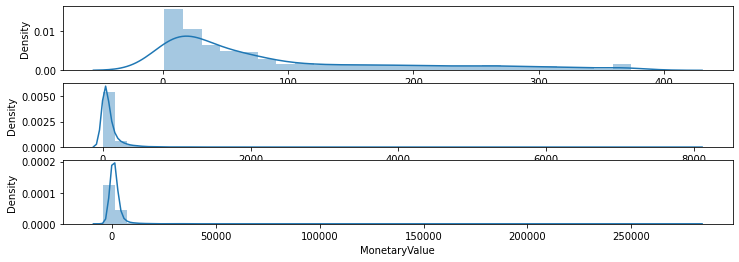

In [17]:
#Inspecting skewness of variables 
# Plot distribution of var1
plt.figure(figsize=(12, 4))
plt.subplot(3, 1, 1); sns.distplot(datamart_rfm['Recency'])

# Plot distribution of var2
plt.subplot(3, 1, 2); sns.distplot(datamart_rfm['Frequency'])

# Plot distribution of var3
plt.subplot(3, 1, 3); sns.distplot(datamart_rfm['MonetaryValue'])

# Show the plot
plt.show()

In [19]:
#Slice only to customer ID which has positive Monetary value
datamart_rfm = datamart_rfm[datamart_rfm['MonetaryValue']>0]
#Unskewed the data
datamart_log = np.log(datamart_rfm)

#Normalise the variables
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(datamart_log)

#Store for clustering 
datamart_normalised = scaler.transform(datamart_log)

# Create a pandas DataFrame
datamart_normalised = pd.DataFrame(data=datamart_normalised, index=datamart_rfm.index, columns=datamart_rfm.columns)

/Users/huedinh/venv36/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/huedinh/venv36/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/huedinh/venv36/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `h

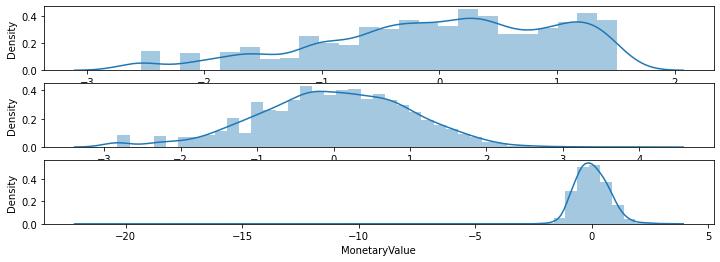

In [20]:
plt.figure(figsize=(12, 4))
# Plot distribution of Recency
plt.subplot(3, 1, 1); sns.distplot(datamart_normalised['Recency'])

# Plot distribution of Frequency
plt.subplot(3, 1, 2); sns.distplot(datamart_normalised['Frequency'])

# Plot distribution of Monetary
plt.subplot(3, 1, 3); sns.distplot(datamart_normalised['MonetaryValue'])

# Show the plot
plt.show()

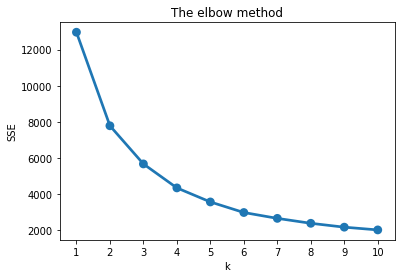

In [21]:
#Choosing the optimal k from elbow criterion method
from sklearn.cluster import KMeans
#Elbow criterion method
#Fit Kmeans and calculate SSE for each k
sse = {}
for k in range(1,11):
    kmeans = KMeans(n_clusters=k, random_state=1) 
    kmeans.fit(datamart_normalised)
    sse[k] = kmeans.inertia_
    
#plot SSE for each k
plt.title('The elbow method')
plt.xlabel('k')
plt.ylabel('SSE')
sns.pointplot(x=list(sse.keys()), y = list(sse.values()))
plt.show()

In [22]:
# Initialize KMeans 4
kmeans4 = KMeans(n_clusters=4, random_state=1) 

# Fit k-means clustering on the normalized data set
kmeans4.fit(datamart_normalised)

# Extract cluster labels
cluster_labels_k4 = kmeans4.labels_

In [24]:

#Create a cluster label column in the original dataframe
datamart_rfm_k4 = datamart_rfm.assign(Cluster = cluster_labels_k4)

In [26]:
#Analysing average RMF values of each cluster 


#Calculate average RMF values and size for each cluster 
datamart_rfm_k4.groupby(['Cluster']).agg({
    'Recency':'mean',
    'Frequency':'mean',
    'MonetaryValue':['mean', 'count']
}).round(1)

Recency Frequency MonetaryValue      
           mean      mean          mean count
Cluster                                      
0           9.7     246.1        5533.2  1041
1          71.2      71.7        1160.5  1796
2         170.3      14.4         316.9  1480
3          69.8      56.0           0.0     5

In [27]:
# Initialize KMeans 5
kmeans5 = KMeans(n_clusters=5, random_state=1) 

# Fit k-means clustering on the normalized data set
kmeans5.fit(datamart_normalised)

# Extract cluster labels
cluster_labels_k5 = kmeans5.labels_

In [28]:
#Create a cluster label column in the original dataframe
datamart_rfm_k5 = datamart_rfm.assign(Cluster = cluster_labels_k5)

In [29]:
#Analysing average RMF values of each cluster 


#Calculate average RMF values and size for each cluster 
datamart_rfm_k5.groupby(['Cluster']).agg({
    'Recency':'mean',
    'Frequency':'mean',
    'MonetaryValue':['mean', 'count']
}).round(1)

Recency Frequency MonetaryValue      
           mean      mean          mean count
Cluster                                      
0          16.8      34.6         643.3   764
1          90.4      82.5        1328.0  1376
2         184.5      14.3         309.9  1321
3          69.8      56.0           0.0     5
4          10.7     288.9        6524.7   856

In [30]:
#Melt the data to the long format so RMF values and metric names are stored in 1 column each 
datamart_melt_k4 = pd.melt(datamart_rfm_k4.reset_index(),
                       id_vars = ['CustomerID', 'Cluster'],
                       value_vars = ['Recency', 'Frequency', 'MonetaryValue'],
                       var_name = 'Atrribue',
                       value_name = 'Value')

<AxesSubplot:title={'center':'Snake plot of raw variables'}, xlabel='Atrribue', ylabel='Value'>

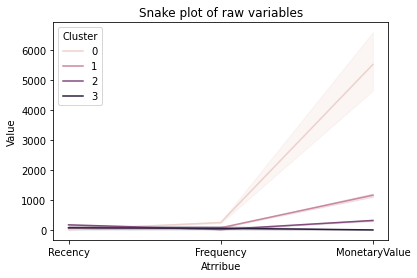

In [32]:
#Visualise a snake plot for k4
plt.title('Snake plot of raw variables')
sns.lineplot(x = 'Atrribue', y = 'Value', hue = 'Cluster', data = datamart_melt_k4)

In [33]:
#Melt the data to the long format so RMF values and metric names are stored in 1 column each 
datamart_melt_k5 = pd.melt(datamart_rfm_k5.reset_index(),
                       id_vars = ['CustomerID', 'Cluster'],
                       value_vars = ['Recency', 'Frequency', 'MonetaryValue'],
                       var_name = 'Atrribue',
                       value_name = 'Value')

<AxesSubplot:title={'center':'Snake plot of raw variables'}, xlabel='Atrribue', ylabel='Value'>

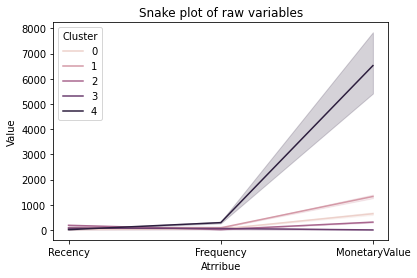

In [34]:
#Visualise a snake plot for k5
plt.title('Snake plot of raw variables')
sns.lineplot(x = 'Atrribue', y = 'Value', hue = 'Cluster', data = datamart_melt_k5)

In [35]:
#Relatiive importance of segment attributes

cluster_avg = datamart_rfm_k4.groupby(['Cluster']).mean()
population_avg = datamart_rfm.mean()
relative_imp = cluster_avg/population_avg - 1

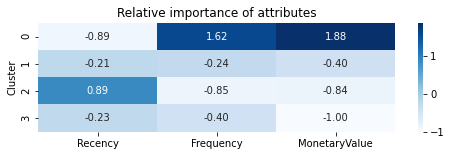

In [36]:
# Initialize a plot with a figure size of 8 by 2 inches 
plt.figure(figsize=(8, 2))

# Add the plot title
plt.title('Relative importance of attributes')

# Plot the heatmap
sns.heatmap(data=relative_imp, annot=True, fmt='.2f', cmap='Blues')
plt.show()

In [37]:
#Relatiive importance of segment attributes

cluster_avg_k5 = datamart_rfm_k5.groupby(['Cluster']).mean()
population_avg = datamart_rfm.mean()
relative_imp_k5 = cluster_avg_k5/population_avg - 1

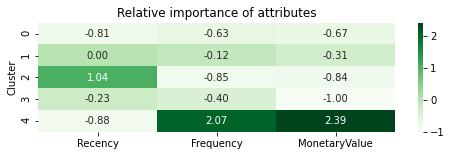

In [38]:
# Initialize a plot with a figure size of 8 by 2 inches 
plt.figure(figsize=(8, 2))

# Add the plot title
plt.title('Relative importance of attributes')

# Plot the heatmap
sns.heatmap(data=relative_imp_k5, annot=True, fmt='.2f', cmap='Greens')
plt.show()